<a href="https://colab.research.google.com/github/eemmy2547/229352/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [ ]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

###hyperparameter


1.   learning rate
2.   Batch size
3.   Epoch

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [ ]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [ ]:
train_loader

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

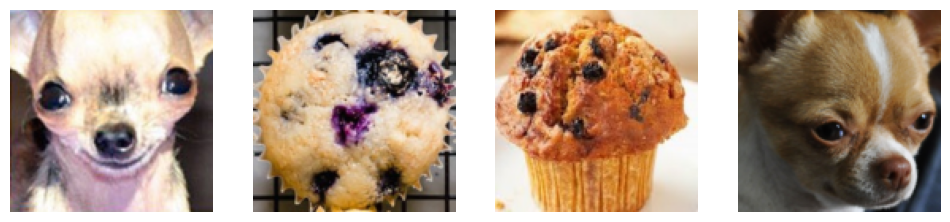

tensor([0, 1, 1, 0])


In [ ]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

In [ ]:
X[0]

array([[[0.7137255 , 0.7529412 , 0.8392157 ],
        [0.72156864, 0.76862746, 0.8509804 ],
        [0.7254902 , 0.7764706 , 0.8509804 ],
        ...,
        [0.6156863 , 0.5921569 , 0.5921569 ],
        [0.6117647 , 0.58431375, 0.58431375],
        [0.5921569 , 0.5647059 , 0.5647059 ]],

       [[0.6666667 , 0.7058824 , 0.8156863 ],
        [0.6784314 , 0.72156864, 0.827451  ],
        [0.68235296, 0.7254902 , 0.827451  ],
        ...,
        [0.65882355, 0.62352943, 0.62352943],
        [0.6392157 , 0.6039216 , 0.6039216 ],
        [0.60784316, 0.5686275 , 0.5686275 ]],

       [[0.5882353 , 0.63529414, 0.7254902 ],
        [0.6117647 , 0.654902  , 0.7372549 ],
        [0.6313726 , 0.6627451 , 0.7490196 ],
        ...,
        [0.65882355, 0.60784316, 0.6039216 ],
        [0.63529414, 0.58431375, 0.5803922 ],
        [0.6039216 , 0.5529412 , 0.54901963]],

       ...,

       [[0.4627451 , 0.40392157, 0.39215687],
        [0.46666667, 0.4117647 , 0.42352942],
        [0.4509804 , 0

In [ ]:
y

tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [ ]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(3 * 128 * 128, 1)
    self.activation = nn.Sigmoid()
  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.activation(x)
    return x


# **อธิบายการทำงานของโค้ด**

โค้ดนี้เป็นการสร้างคลาส `SimpleLogisticRegression` ซึ่งเป็นโมเดลการถดถอยโลจิสติกอย่างง่ายโดยใช้ PyTorch ครับ

*   **`class SimpleLogisticRegression(nn.Module):`**: นี่คือการประกาศคลาสชื่อ `SimpleLogisticRegression` ที่สืบทอดมาจาก `nn.Module` ของ PyTorch การสืบทอดจาก `nn.Module` ทำให้คลาสนี้สามารถใช้งานฟังก์ชันต่างๆ ของ PyTorch ที่จำเป็นสำหรับการสร้างและฝึกโมเดลโครงข่ายประสาทเทียมได้

*   **`def __init__(self):`**: นี่คือเมธอด Constructor ของคลาส ซึ่งจะถูกเรียกเมื่อมีการสร้าง Object ของคลาสนี้ขึ้นมา

    *   **`super(SimpleLogisticRegression, self).__init__()`**: เป็นการเรียก Constructor ของคลาสแม่ (`nn.Module`) เพื่อเริ่มต้นการทำงานของคลาสแม่

    *   **`self.flatten = nn.Flatten()`**: สร้าง Layer ที่ทำหน้าที่ปรับเปลี่ยนรูปทรงของ Input Tensor ให้เป็นแบบ Flatten (แบนราบ) หรือเวกเตอร์หนึ่งมิติ Layer นี้จะถูกเก็บไว้ใน `self.flatten`

    *   **`self.linear = nn.Linear(3 * 128 * 128, 1)`**: สร้าง Linear Layer (หรือ Fully Connected Layer) Layer นี้จะรับ Input ที่มีขนาด `3 * 128 * 128` (ซึ่งมาจากรูปภาพขนาด 128x128 ที่มี 3 Channels สี) และให้ Output ขนาด 1 (เนื่องจากเป็นการจำแนกแบบ Binary Classification: Chihuahua หรือ Muffin) Layer นี้จะถูกเก็บไว้ใน `self.linear`

    *   **`self.activation = nn.Sigmoid()`**: สร้าง Activation Function แบบ Sigmoid ซึ่งจะนำไปใช้กับ Output จาก Linear Layer ฟังก์ชัน Sigmoid จะแปลงค่า Output ให้อยู่ในช่วง 0 ถึง 1 ซึ่งเหมาะสำหรับงาน Binary Classification เพื่อตีความว่าเป็นความน่าจะเป็นของ Class ใด Class หนึ่ง Layer นี้จะถูกเก็บไว้ใน `self.activation`

*   **`def forward(self, x):`**: นี่คือเมธอด `forward` ซึ่งเป็นเมธอดที่สำคัญใน `nn.Module` เมธอดนี้จะกำหนดขั้นตอนการคำนวณของโมเดลเมื่อได้รับ Input `x`

    *   **`x = self.flatten(x)`**: นำ Input `x` มาผ่าน Layer `self.flatten` เพื่อปรับรูปทรงให้เป็นเวกเตอร์หนึ่งมิติ

    *   **`x = self.linear(x)`**: นำ Output จากขั้นตอนก่อนหน้ามาผ่าน Linear Layer `self.linear` เพื่อคำนวณค่า Weighted Sum และ Bias

    *   **`x = self.activation(x)`**: นำ Output จาก Linear Layer มาผ่าน Activation Function แบบ Sigmoid `self.activation` เพื่อให้ได้ค่าความน่าจะเป็น

    *   **`return x`**: คืนค่า Output สุดท้ายของโมเดล ซึ่งเป็นค่าความน่าจะเป็นที่ Input `x` จะเป็น Class ใด Class หนึ่ง (ในที่นี้คือ Muffin)

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [ ]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [ ]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [ ]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [ ]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [ ]:
X, y = next(train_batches) # if you want one more batch

#### Make a prediction on the minibatch (Forward pass)

In [ ]:
y_hat = model(X)

y_hat = y_hat[:, 0]
y = y.to(torch.float32)
#print(y_hat.shape)
#print(y_hat)


#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [ ]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())


#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

In [ ]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [ ]:
for param in model.parameters():
  print(param.grad)

tensor([[0.0935, 0.0920, 0.0925,  ..., 0.0529, 0.0439, 0.0467]])
tensor([0.2000])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad


# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [ ]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[1.060147762298584]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

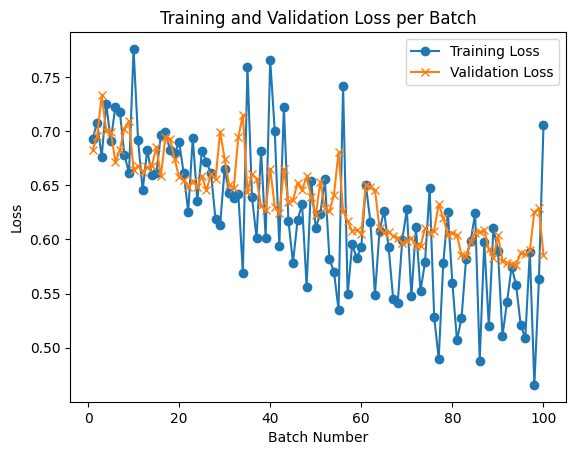

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [ ]:
class ThreeLayerNeuralNetwork(nn.Module):
    def __init__(self):
        super(ThreeLayerNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 128 * 128, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


In [ ]:
def train_model(learning_rate, num_epochs):
    model = ThreeLayerNeuralNetwork()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses_epoch = []
    val_losses_epoch = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for X, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses_epoch.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                y_hat = y_hat[:, 0]
                y = y.to(torch.float32)
                val_loss = criterion(y_hat, y)
                running_val_loss += val_loss.item()
            val_losses_epoch.append(running_val_loss / len(val_loader))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses_epoch[-1]:.4f}, Val Loss: {val_losses_epoch[-1]:.4f}')

    return train_losses_epoch, val_losses_epoch

In [ ]:
learning_rates_to_experiment = [1e-2, 1e-3, 1e-4, 1e-5]
all_train_losses = {}
all_val_losses = {}

In [ ]:
for lr in all_train_losses.keys():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), all_train_losses[lr], marker='o', linestyle='-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), all_val_losses[lr], marker='x', linestyle='-', label='Validation Loss')
    plt.title(f'Training and Validation Loss for Learning Rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
num_epochs = 20
for lr in learning_rates_to_experiment:
    print(f"Training with learning rate: {lr}")
    train_losses, val_losses = train_model(lr, num_epochs)
    all_train_losses[lr] = train_losses
    all_val_losses[lr] = val_losses

Training with learning rate: 0.01
Epoch 1/20, Train Loss: 47.0694, Val Loss: 62.5000
Epoch 2/20, Train Loss: 51.3333, Val Loss: 62.5000
Epoch 3/20, Train Loss: 52.0000, Val Loss: 62.5000
Epoch 4/20, Train Loss: 52.6667, Val Loss: 62.5000
Epoch 5/20, Train Loss: 52.6667, Val Loss: 62.5000
Epoch 6/20, Train Loss: 52.6667, Val Loss: 62.5000
Epoch 7/20, Train Loss: 54.0000, Val Loss: 62.5000
Epoch 8/20, Train Loss: 51.3333, Val Loss: 62.5000
Epoch 9/20, Train Loss: 52.6667, Val Loss: 62.5000
Epoch 10/20, Train Loss: 52.0000, Val Loss: 62.5000
Epoch 11/20, Train Loss: 52.0000, Val Loss: 62.5000
Epoch 12/20, Train Loss: 52.0000, Val Loss: 62.5000
Epoch 13/20, Train Loss: 52.6667, Val Loss: 62.5000
Epoch 14/20, Train Loss: 51.3333, Val Loss: 62.5000
Epoch 15/20, Train Loss: 50.6667, Val Loss: 62.5000
Epoch 16/20, Train Loss: 52.0000, Val Loss: 62.5000
Epoch 17/20, Train Loss: 53.3333, Val Loss: 62.5000
Epoch 18/20, Train Loss: 50.6667, Val Loss: 62.5000
Epoch 19/20, Train Loss: 54.0000, Val L

In [ ]:
best_learning_rate = 1e-3

model = ThreeLayerNeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

    # Optional: Print epoch loss to track training progress
    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}')
model.eval()
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        predicted_labels = (y_hat > 0.5).float()
        correct_predictions += (predicted_labels == y.to(torch.float32)).sum().item()
        total_predictions += y.size(0)

accuracy = correct_predictions / total_predictions

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7333


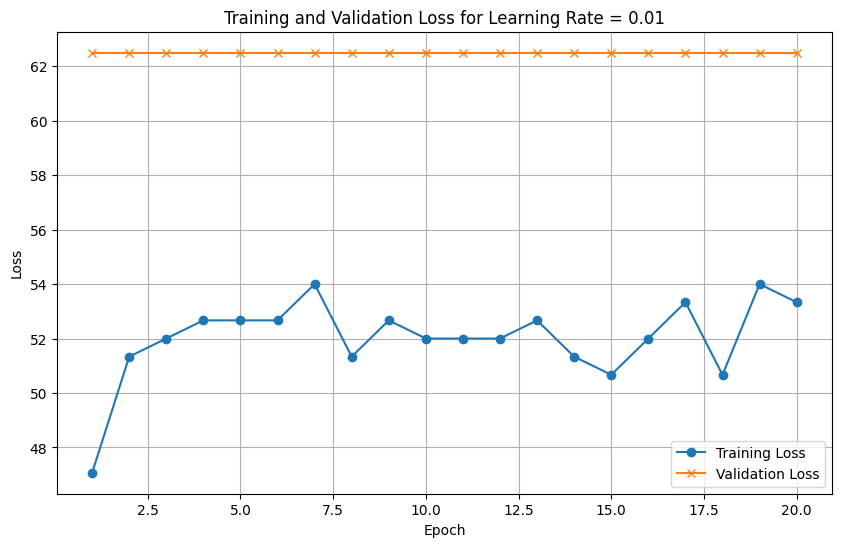

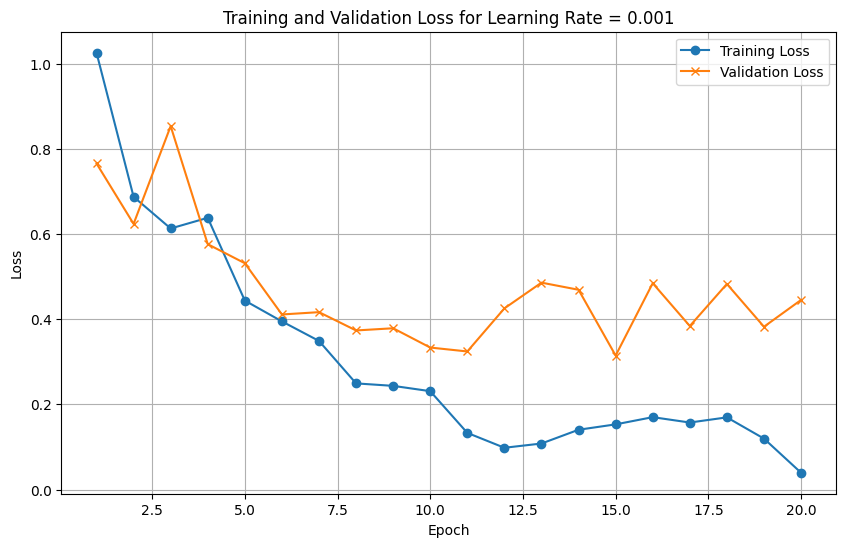

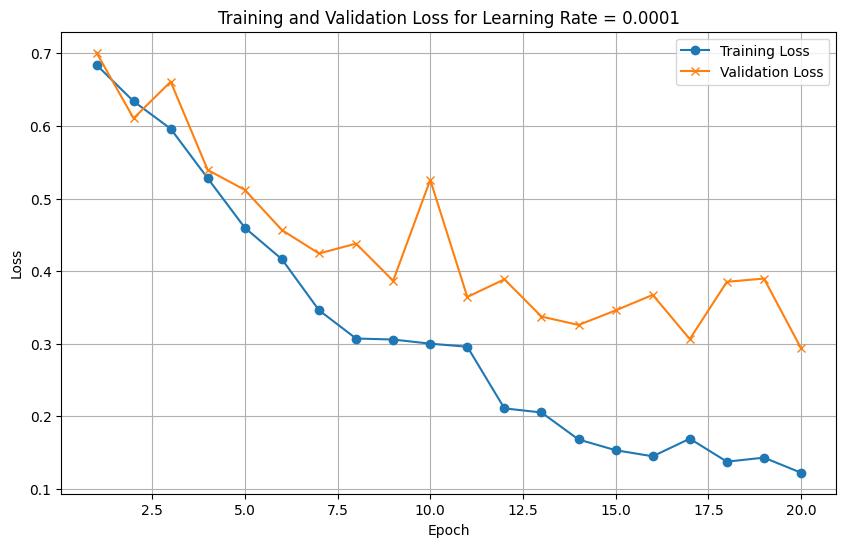

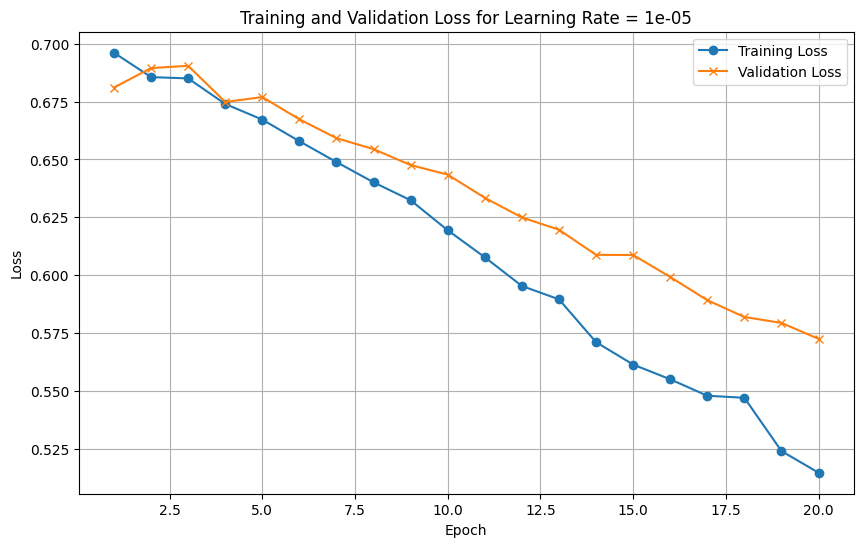

In [ ]:
for lr in all_train_losses.keys():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), all_train_losses[lr], marker='o', linestyle='-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), all_val_losses[lr], marker='x', linestyle='-', label='Validation Loss')
    plt.title(f'Training and Validation Loss for Learning Rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()